# PAGA for hematopoiesis in mouse [(Paul et al., 2015)](https://doi.org/10.1016/j.cell.2015.11.013)

## Tracing myeloid and erythroid differentiation for data of Paul et al. (2015).
https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

In [14]:
!pip install fa2

     |████████████████████████████████| 440kB 1.7MB/s eta 0:00:01     |█████████▉                      | 133kB 1.7MB/s eta 0:00:01     |█████████████████▎              | 235kB 1.7MB/s eta 0:00:01
  Created wheel for fa2: filename=fa2-0.3.5-cp37-cp37m-linux_x86_64.whl size=297643 sha256=791000e34752f21041bfc35da99a825a124b587005c01feaae4873c4940d430e
  Stored in directory: /home/ivory/.cache/pip/wheels/4f/44/5b/d4fef7f6a310279e27dace5099b8f8104dcc3a9a046004524f
Successfully built fa2


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [2]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


In [10]:
sc.settings.set_figure_params(dpi=120, frameon=False)  # low dpi (dots per inch) yields small inline figures

In [4]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

### Let us work with a higher precision than the default ‘float32’ to ensure exactly the same results across different computational platforms.

In [5]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

## Preprocessing and Visualization

### Apply a simple preprocessing recipe.

In [6]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
    finished (0:00:03)


In [7]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:01)


In [8]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:01:01)


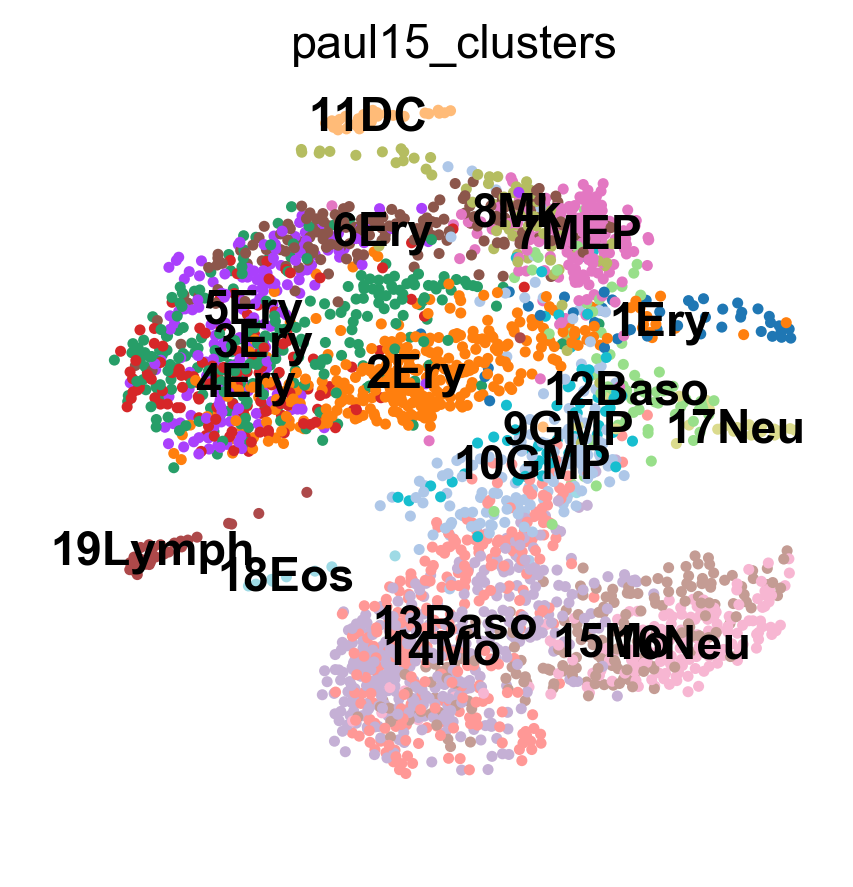

In [11]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

#### This looks like a mess. We need to do some denoising

### Denoising the graph

To denoise the graph, we represent it in diffusion map space (and not in PCA space). Computing distances within a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components. It’s very similar to denoising a data matrix using PCA. The approach has been used in a couple of papers, see e.g. Schiebinger et al. (2017) or Tabaka et al. (2018). It’s also related to the principles behind MAGIC Dijk et al. (2018).

In [12]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989277  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:02)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)


In [13]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:05:16)


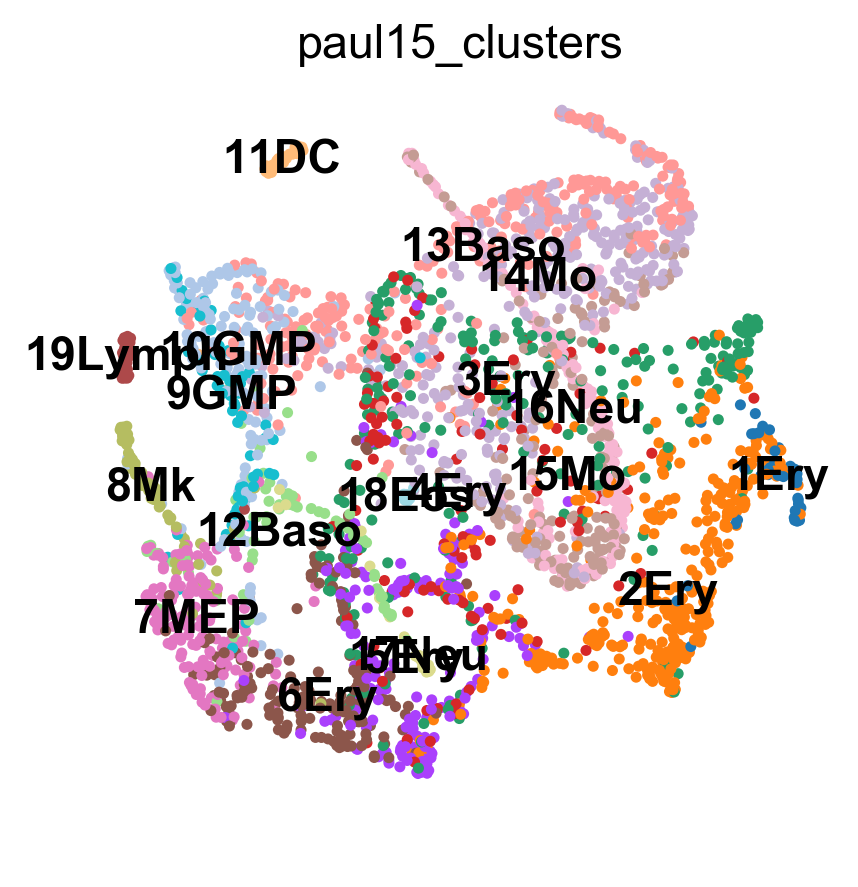

In [15]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

#### This still looks messy, but in a different way: a lot of the branches are overplotted.

## Clustering and PAGA

In [16]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


#### Annotate the clusters using marker genes.

### For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [17]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


/home/ivory/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/ivory/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_ve

--> added 'pos', the PAGA positions (adata.uns['paga'])


/home/ivory/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


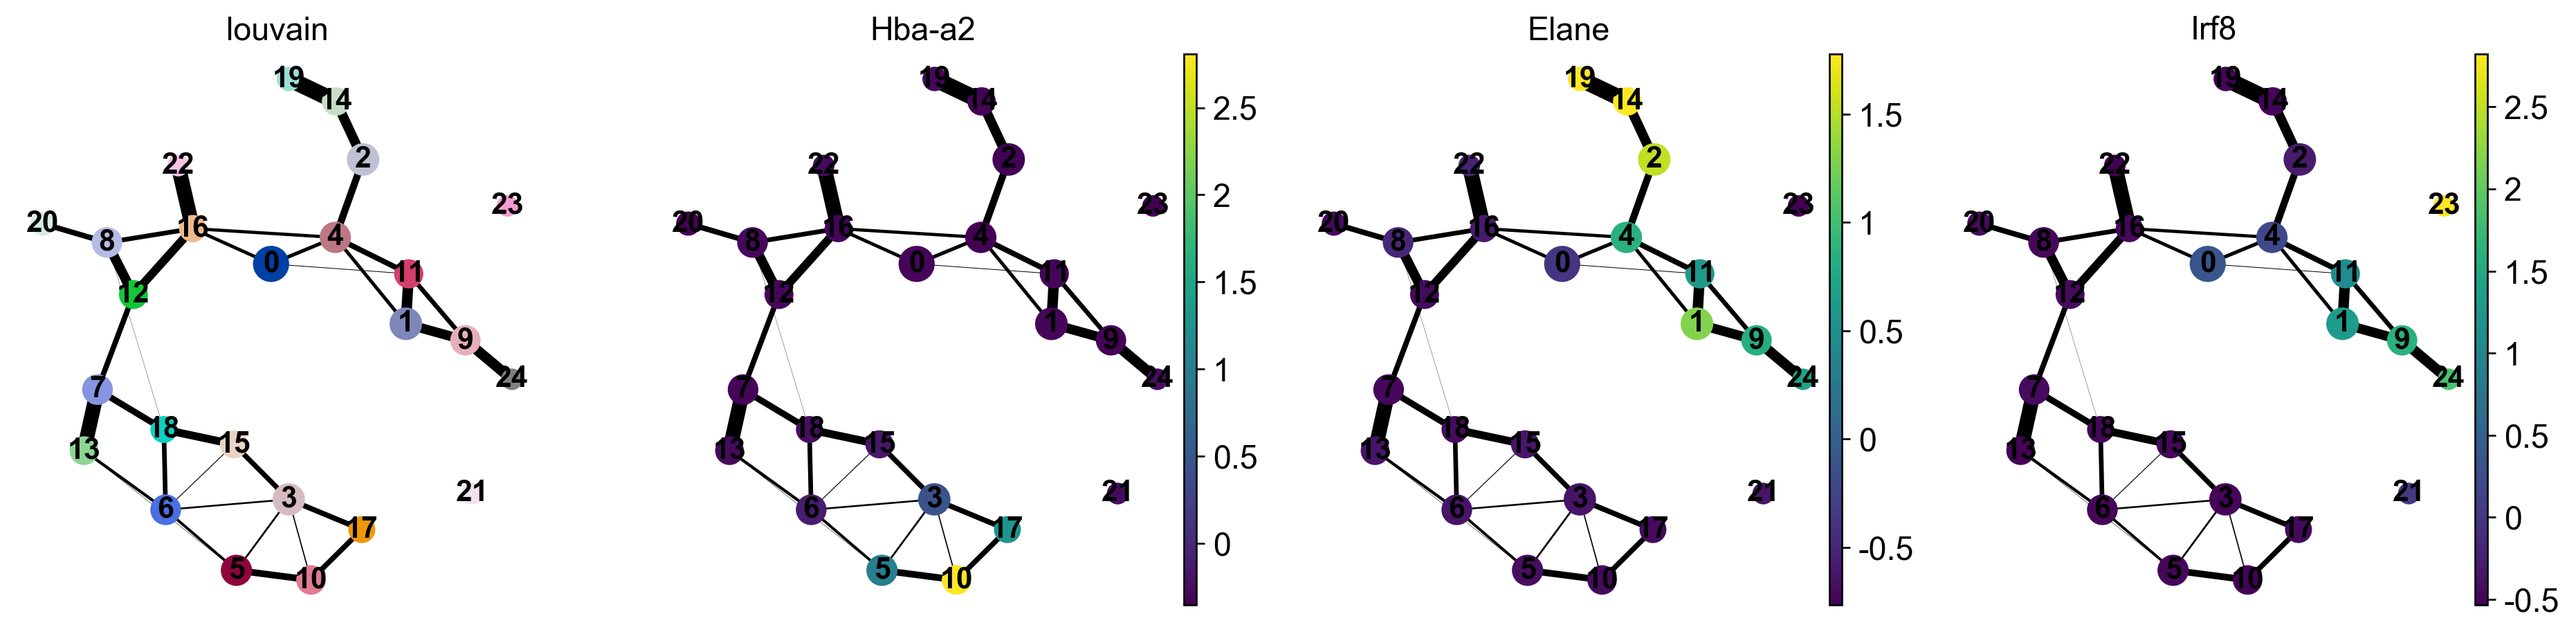

In [18]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])


/home/ivory/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/home/ivory/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_ve

--> added 'pos', the PAGA positions (adata.uns['paga'])


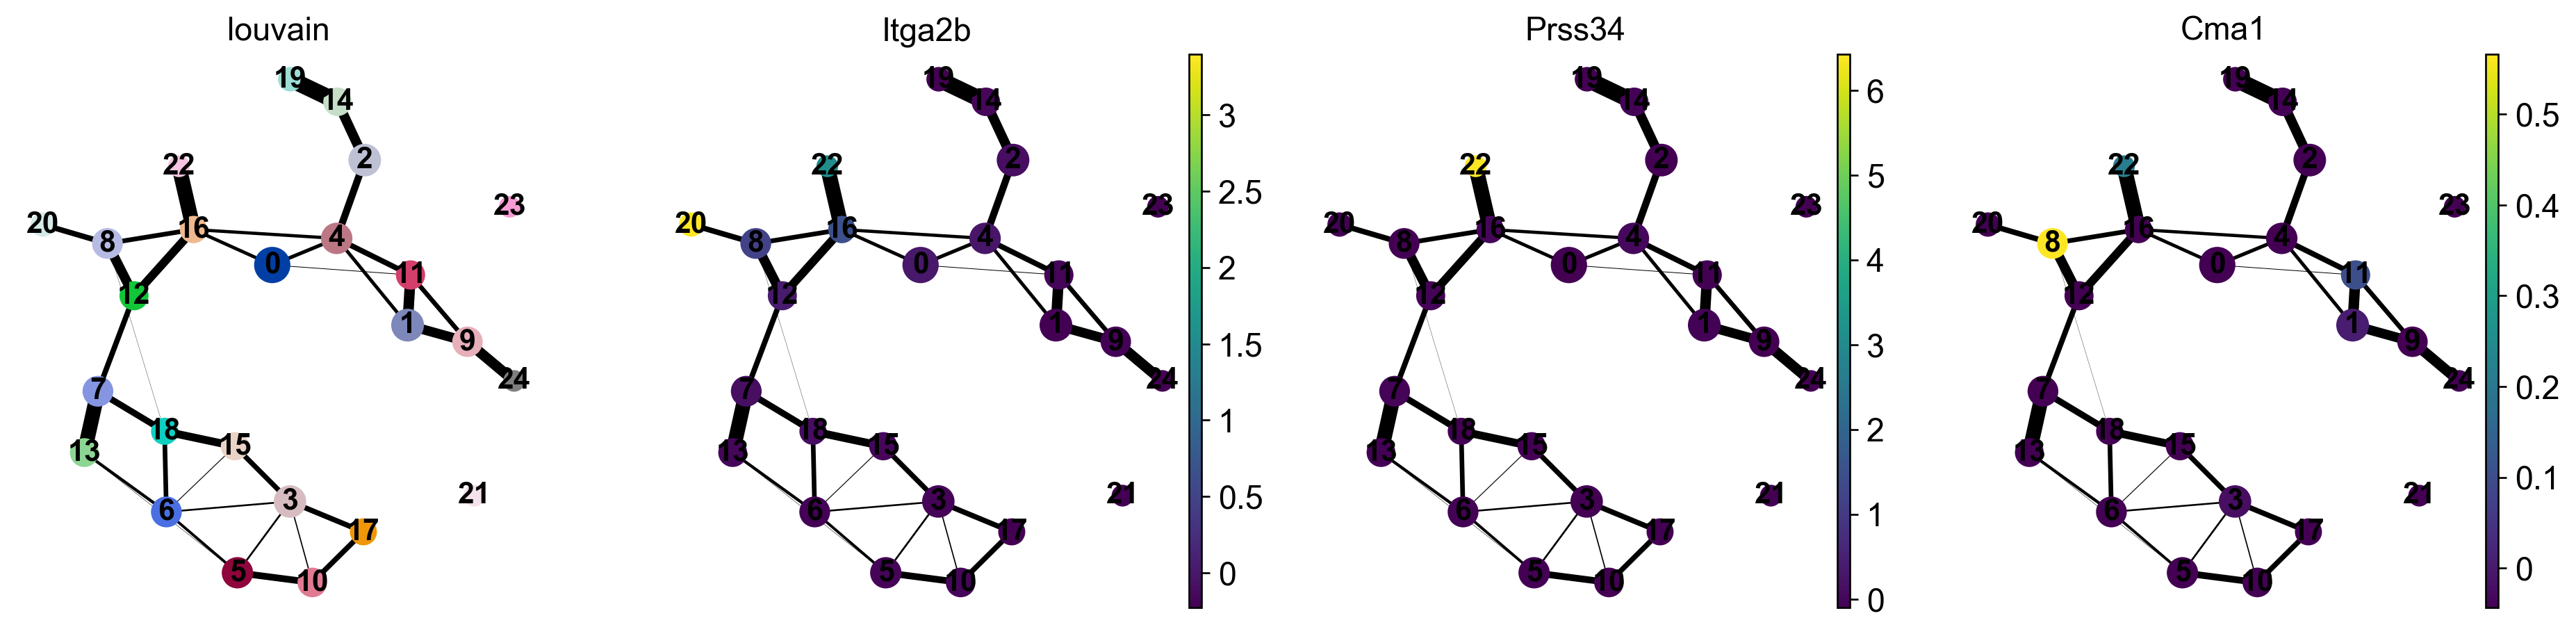

In [19]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

#### Annotate the clusters — note that Cma1 is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.

In [20]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [21]:
adata.obs['louvain_anno'] = adata.obs['louvain']


#### Let’s use the annotated clusters for PAGA.

In [22]:
sc.tl.paga(adata, groups='louvain_anno')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)


--> added 'pos', the PAGA positions (adata.uns['paga'])


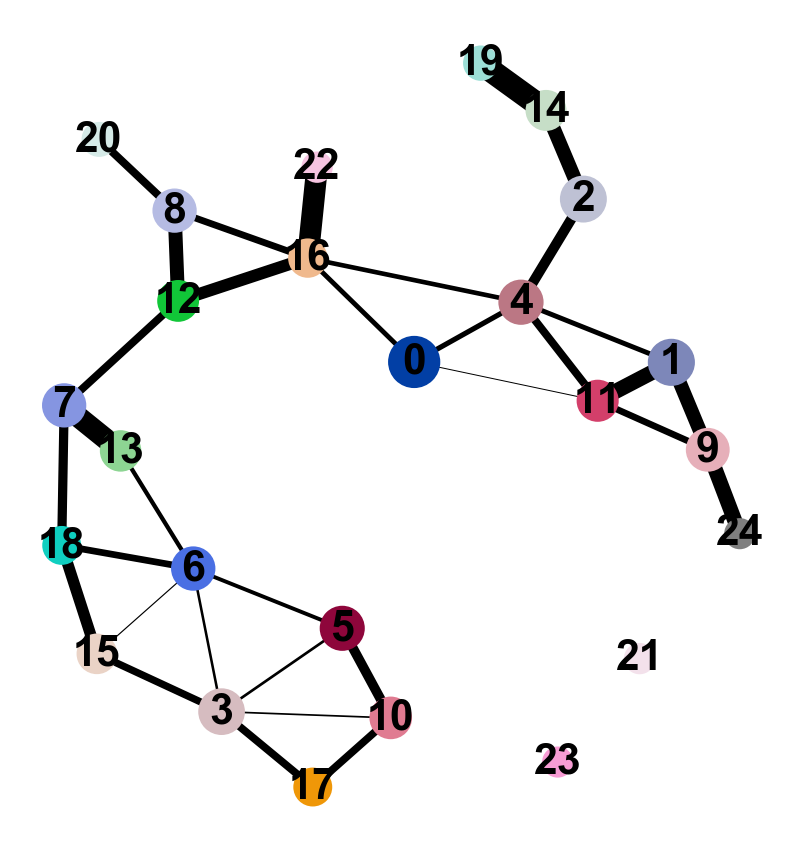

In [23]:
sc.pl.paga(adata, threshold=0.03)

### Recomputing the embedding using PAGA-initialization
The following is just as well possible for a UMAP.

In [24]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:27)


### Now we can see all marker genes also at single-cell resolution in a meaningful layout.

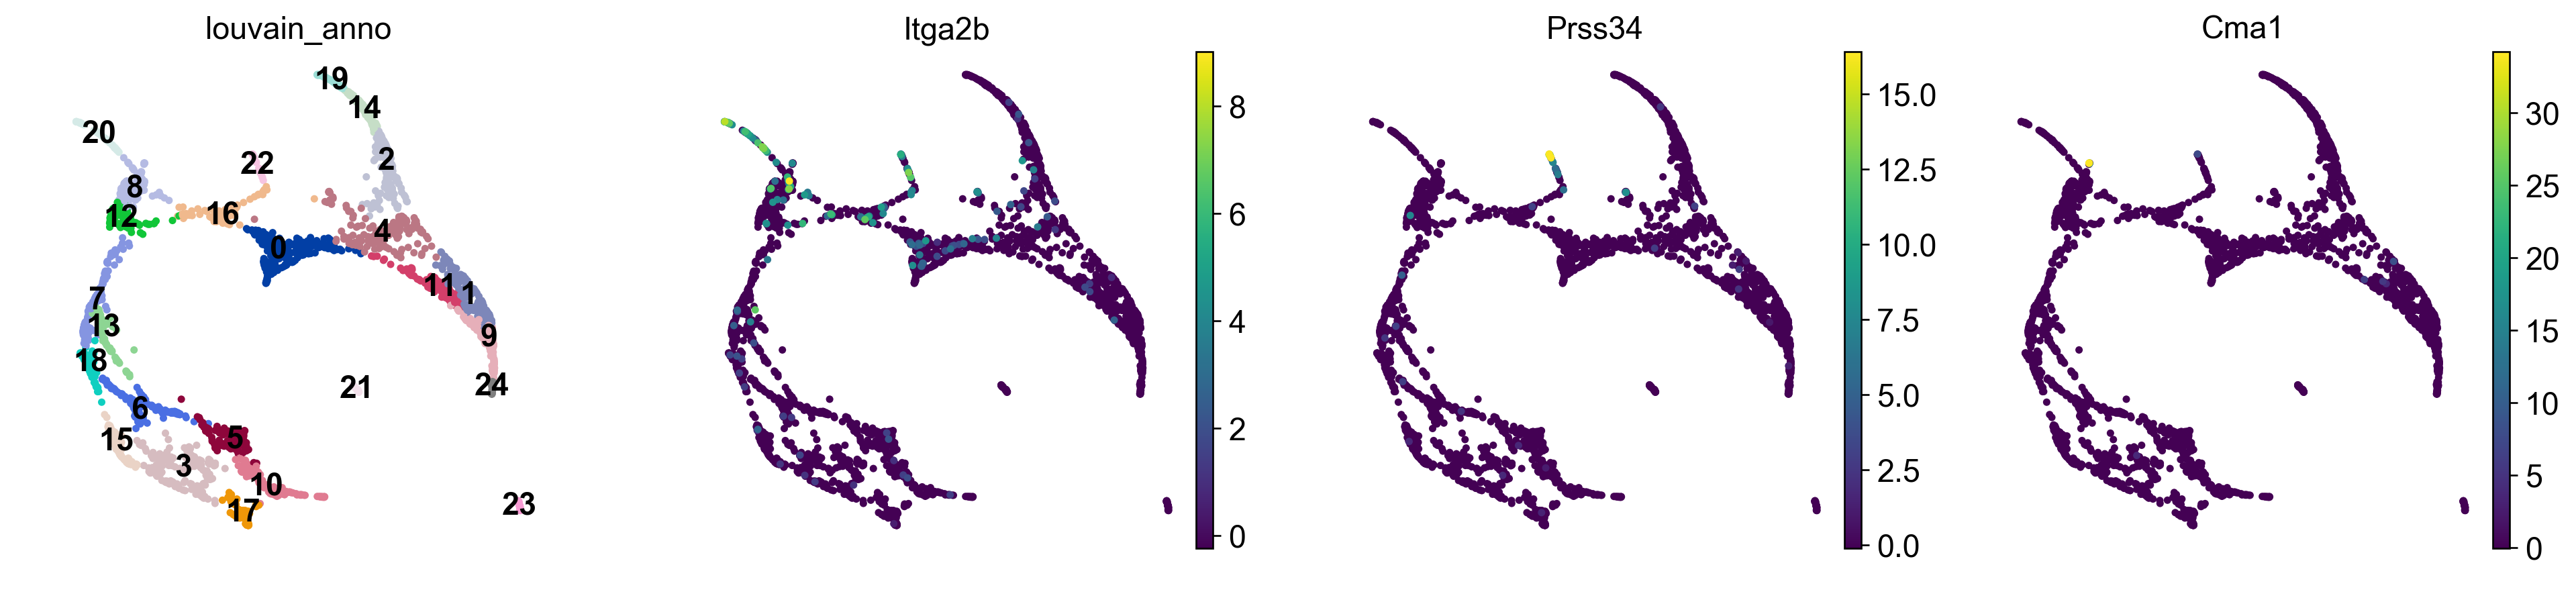

In [26]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')


#### Choose the colors of the clusters more consistently

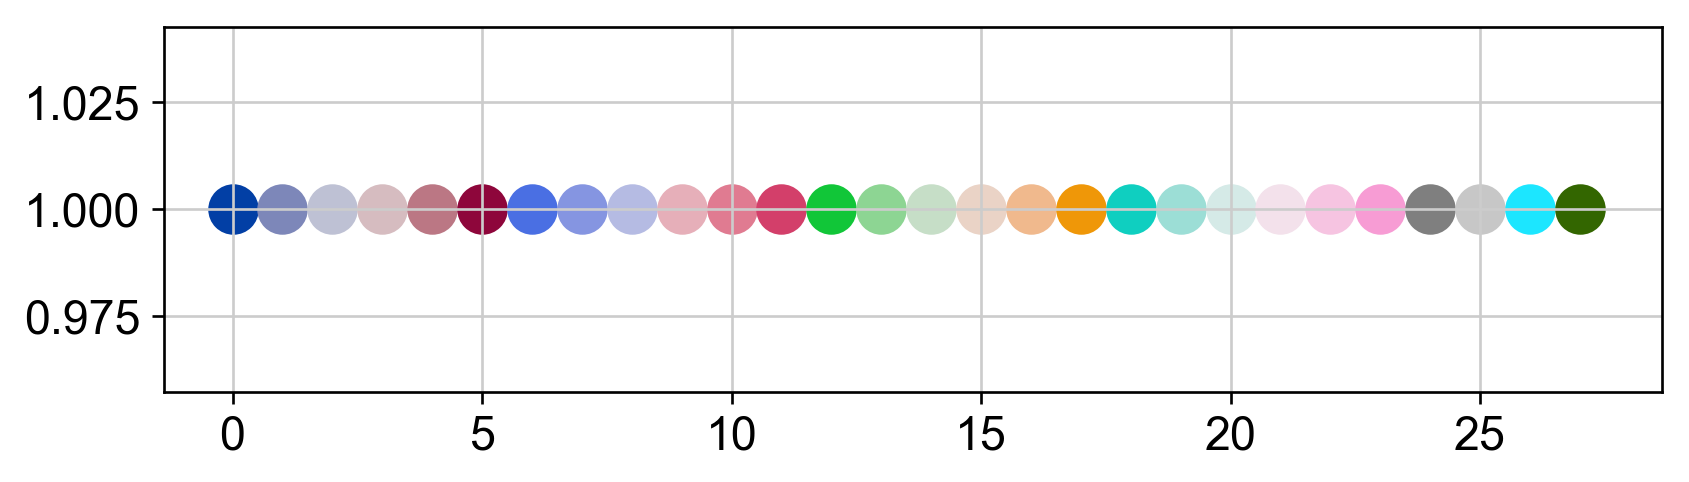

In [27]:

pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_26[i], s=200)
pl.show()

In [28]:

zeileis_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [30]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [31]:
adata.uns['louvain_anno_colors'] = new_colors

#### And add some white space to some cluster names. The layout shown here differs from the one in the paper, which can be found here. These differences, however, are only cosmetic. We had to change the layout as we moved from a randomized PCA and float32 to float64 precision.

--> added 'pos', the PAGA positions (adata.uns['paga'])


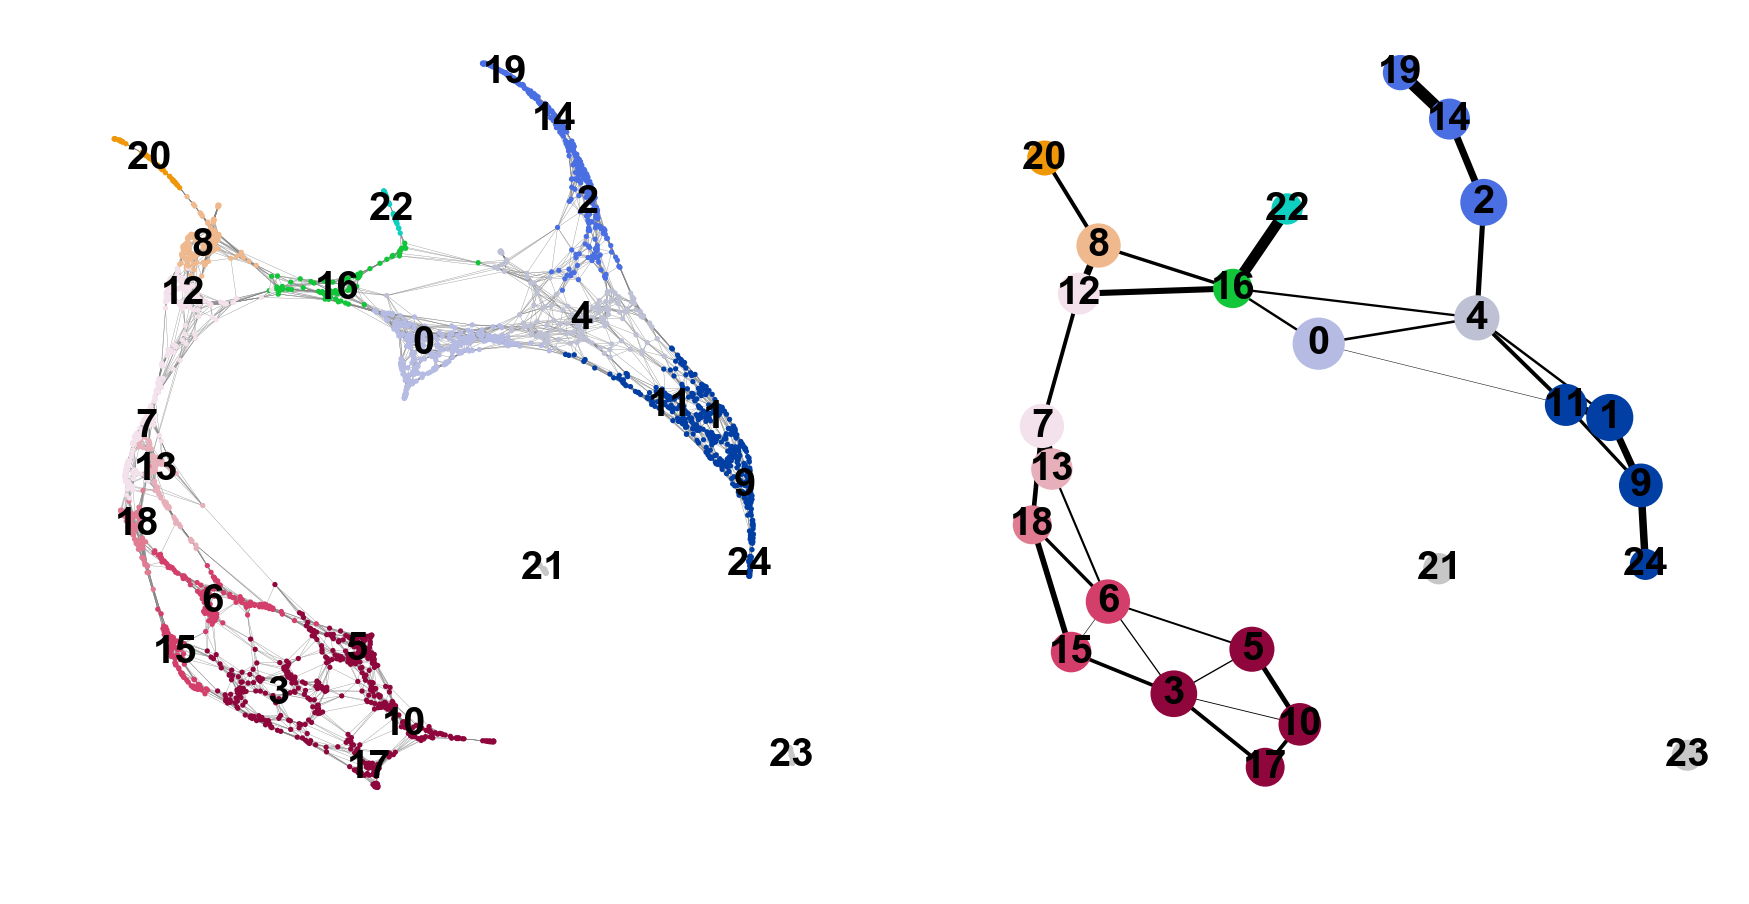

In [32]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)
